In [769]:
# from eval import *
# from environment_v2 import get_task_info
import glob
import os
import json
import glob
# import tiktoken

# # enc = tiktoken.get_encoding("cl100k_base")
# # assert enc.decode(enc.encode("hello world")) == "hello world"

# # # To get the tokeniser corresponding to a specific model in the OpenAI API:
# enc = tiktoken.encoding_for_model("gpt-4")

In [770]:
# from transformers import GPT2TokenizerFast
# tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

# for t in os.listdir("/dfs/user/qhwang/research_assistant/benchmarks/"):
#     try:
#         f = open(f"benchmarks/{t}/env/train.py").read()
#     except:
#         continue
#     print(t)
#     print(len(enc.encode(f)))
#     # print(len(tokenizer(f)["input_ids"]))


In [771]:

def estimate_tokens(path):
    prompt_tokens = 0
    completed_tokens = 0
    num_steps = 0
    step_logs = path.replace("trace.json", "../agent_log/*.log")
    try:
        for file in glob.glob(step_logs):
            with open(file, "r") as f:
                for line in f:
                    if "Number of prompt tokens:" in line:
                        prompt_tokens += int(line.split(":")[1])
                    if "Number of sampled tokens:" in line:
                        completed_tokens += int(line.split(":")[1])
        num_steps = len(json.load(open(path, "r"))["steps"])
    except:
        pass
    try:
        total_time = float(open(path.replace("trace.json", "overall_time.txt"), "r").read())
    except:
        total_time = 0
    tool_step_logs = path.replace("trace.json", "tool_logs/*.log")
    tool_prompt_tokens = 0
    tool_completed_tokens = 0
    try:
        for file in glob.glob(tool_step_logs):
            with open(file, "r") as f:
                if "Given this python script:" not in f.read():
                    continue
            with open(file, "r") as f:
                for line in f:
                    if "Number of prompt tokens:" in line:
                        tool_prompt_tokens += int(line.split(":")[1])
                    if "Number of sampled tokens:" in line:
                        tool_completed_tokens += int(line.split(":")[1])
    except Exception as e:
        print(e)
        pass
    return prompt_tokens, completed_tokens, tool_prompt_tokens, tool_completed_tokens, num_steps, total_time
                
    

In [772]:
def oom_error(path):
    log = path.replace("trace.json", "../log")
    main_log = path.replace("trace.json", "../agent_log/main_log")
    message = "CUDA out of memory"
    return (message in open(log, "r").read()) or (message in open(main_log, "r").read())
    

def connection_error(path):
    log = path.replace("trace.json", "../log")
    main_log = path.replace("trace.json", "../agent_log/main_log")
    bad = ["You exceeded your current quota, please check your plan and billing details.", "Error: 'text-similarity-ada-001'", "Error: 'text-embedding-ada-001'"]
    return ("Connection aborted" in open(log, "r").read()) or (any([b in open(main_log, "r").read() for b in bad])) 


def langchain_error(path):
    return "langchain.schema.OutputParserException" in open(os.path.join(path.replace("trace.json", ""), "error.txt"), "r").read()


def error(path):
    return (os.path.exists(os.path.join(path.replace("trace.json", ""), "error.txt")) and not langchain_error(path)) or not os.path.exists(os.path.join(path.replace("trace.json", ""), "overall_time.txt")) 


def json_error(path):
    main_log = path.replace("trace.json", "../agent_log/main_log")
    return open(main_log, "r").read().count("JSONDecodeError") > 2


def langchain_final(path):
    return "Final Answer" in open(path.replace("trace.json", "../agent_log/main_log"), "r").read()

def autogpt_final(path):
    return "Goal achieved" in open(path.replace("trace.json", "../agent_log/main_log"), "r").read()
        
def long_prompt_error(path):
    main_log = path.replace("trace.json", "../agent_log/main_log")
    return "EnvError: too long input for the tool" in open(main_log, "r").read()

In [773]:
# all_runs = glob.glob("final_exp_logs/*/*/*/env_log/trace.json")
all_runs = glob.glob("../nlp_logs/lfs/local/0/qhwang/final_exp_logs/*/*/*/env_log/trace.json")
all_runs.extend(glob.glob("../nlp_logs/final_exp_logs*/*/*/*/env_log/trace.json"))
import pandas as pd
df = pd.DataFrame()
for r in all_runs:
    exp, task, run = r.split("/")[-5:-2]
    if task in os.listdir("benchmarks"):
        new_row={"task": task, "exp": exp, "run": run, "path": r}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [774]:
# df = df[df["exp"].isin(["full","full_gpt4","autogpt", "sanity_check"])]

In [775]:
# remove error runs

In [776]:
df["error"] = df["path"].apply(error)
df["json_error"] = df["path"].apply(json_error)
df["long_prompt_error"] = df["path"].apply(long_prompt_error)
df["oom_error"] = df["path"].apply(oom_error)
df["connection_error"] = df["path"].apply(connection_error)
print(len(df[df["error"] | df["connection_error"]]))

123


In [777]:
print(len(df[df["oom_error"]]))

12


In [778]:
# df[(df["error"] | df["connection_error"]) & (df["exp"] == "autogpt")& (df["task"] == "amp-parkinsons-disease-progression-prediction")]

In [779]:

df[ ["exp","task","error","json_error", "connection_error", "oom_error"]].groupby([ "exp","task"]).sum()


error  \
exp          task                                                        
autogpt      CLRS                                                    0   
             amp-parkinsons-disease-progression-prediction           0   
             babylm                                                  0   
             cifar10_training                                        0   
             fathomnet-out-of-sample-detection                       0   
...                                                                ...   
sanity_check cifar10_training                                        0   
             fathomnet-out-of-sample-detection                       0   
             feedback-prize-english-language-learning                0   
             google-research-identify-contrails-reduce-globa...      0   
             imdb                                                    0   

                                                                 json_error  \
exp          task                                                             
autogpt      CLRS                                                         0   
             amp-parkinsons-disease-progression-prediction                0   
             babylm                                                       0   
             cifar10_training                                             0   
             fathomnet-out-of-sample-detection                            0   
...                                                                     ...   
sanity_check cifar10_training                                             0   
             fathomnet-out-of-sample-detection                            0   
             feedback-prize-english-language-learning                     0   
             google-research-identify-contrails-reduce-globa...           0   
             imdb                                                         0   

                                                                 connection_error  \
exp          task                                                                   
autogpt      CLRS                                                               0   
             amp-parkinsons-disease-progression-prediction                      0   
             babylm                                                             0   
             cifar10_training                                                   0   
             fathomnet-out-of-sample-detection                                  0   
...                                                                           ...   
sanity_check cifar10_training                                                   0   
             fathomnet-out-of-sample-detection                                  0   
             feedback-prize-english-language-learning                           0   
             google-research-identify-contrails-reduce-globa...                 0   
             imdb                                                               0   

                                                                 oom_error  
exp          task                                                           
autogpt      CLRS                                                        0  
             amp-parkinsons-disease-progression-prediction               0  
             babylm                                                      3  
             cifar10_training                                            0  
             fathomnet-out-of-sample-detection                           0  
...                                                                    ...  
sanity_check cifar10_training                                            0  
             fathomnet-out-of-sample-detection                           0  
             feedback-prize-english-language-learning                    0  
             google-research-identify-contrails-reduce-globa...          0  
             imdb                           

In [780]:

df[df["exp"] == "sanity_check"][ ["exp","task","error","json_error", "connection_error", "oom_error"]].groupby([ "exp","task"]).sum()


error  \
exp          task                                                        
sanity_check CLRS                                                    0   
             amp-parkinsons-disease-progression-prediction           0   
             babylm                                                  0   
             cifar10_training                                        0   
             fathomnet-out-of-sample-detection                       0   
             feedback-prize-english-language-learning                0   
             google-research-identify-contrails-reduce-globa...      0   
             imdb                                                    0   

                                                                 json_error  \
exp          task                                                             
sanity_check CLRS                                                         0   
             amp-parkinsons-disease-progression-prediction                0   
             babylm                                                       0   
             cifar10_training                                             0   
             fathomnet-out-of-sample-detection                            0   
             feedback-prize-english-language-learning                     0   
             google-research-identify-contrails-reduce-globa...           0   
             imdb                                                         0   

                                                                 connection_error  \
exp          task                                                                   
sanity_check CLRS                                                               0   
             amp-parkinsons-disease-progression-prediction                      0   
             babylm                                                             0   
             cifar10_training                                                   0   
             fathomnet-out-of-sample-detection                                  0   
             feedback-prize-english-language-learning                           0   
             google-research-identify-contrails-reduce-globa...                 0   
             imdb                                                               0   

                                                                 oom_error  
exp          task                                                           
sanity_check CLRS                                                        0  
             amp-parkinsons-disease-progression-prediction               0  
             babylm                                                      0  
             cifar10_training                                            0  
             fathomnet-out-of-sample-detection                           0  
             feedback-prize-english-language-learning                    0  
             google-research-identify-contrails-reduce-globa...          0  
             imdb                                                        0

In [781]:

df[df["exp"] == "langchain"][ ["exp","task","error","json_error", "connection_error", "oom_error"]].groupby([ "exp","task"]).count()


error  \
exp       task                                                        
langchain amp-parkinsons-disease-progression-prediction          34   
          cifar10_training                                       74   
          fathomnet-out-of-sample-detection                       9   
          feedback-prize-english-language-learning               30   
          google-research-identify-contrails-reduce-globa...      9   
          imdb                                                   40   
          kaggle_training_class                                  10   
          kaggle_training_reg                                    10   

                                                              json_error  \
exp       task                                                             
langchain amp-parkinsons-disease-progression-prediction               34   
          cifar10_training                                            74   
          fathomnet-out-of-sample-detection                            9   
          feedback-prize-english-language-learning                    30   
          google-research-identify-contrails-reduce-globa...           9   
          imdb                                                        40   
          kaggle_training_class                                       10   
          kaggle_training_reg                                         10   

                                                              connection_error  \
exp       task                                                                   
langchain amp-parkinsons-disease-progression-prediction                     34   
          cifar10_training                                                  74   
          fathomnet-out-of-sample-detection                                  9   
          feedback-prize-english-language-learning                          30   
          google-research-identify-contrails-reduce-globa...                 9   
          imdb                                                              40   
          kaggle_training_class                                             10   
          kaggle_training_reg                                               10   

                                                              oom_error  
exp       task                                                           
langchain amp-parkinsons-disease-progression-prediction              34  
          cifar10_training                                           74  
          fathomnet-out-of-sample-detection                           9  
          feedback-prize-english-language-learning                   30  
          google-research-identify-contrails-reduce-globa...          9  
          imdb                                                       40  
          kaggle_training_class                                      10  
          kaggle_training_reg                                        10

In [782]:
df = df[(((~df["error"]) & (~df["connection_error"])) | df["exp"].isin(["no_retrieval_gpt4", "full_gpt4_long"]))& (~df["oom_error"])]

In [783]:
# count runs

In [784]:
df[ ["exp","task","error","json_error", "connection_error", "oom_error"]].groupby([ "exp","task"]).sum()


error  \
exp          task                                                        
autogpt      CLRS                                                    0   
             amp-parkinsons-disease-progression-prediction           0   
             babylm                                                  0   
             cifar10_training                                        0   
             fathomnet-out-of-sample-detection                       0   
...                                                                ...   
sanity_check cifar10_training                                        0   
             fathomnet-out-of-sample-detection                       0   
             feedback-prize-english-language-learning                0   
             google-research-identify-contrails-reduce-globa...      0   
             imdb                                                    0   

                                                                 json_error  \
exp          task                                                             
autogpt      CLRS                                                         0   
             amp-parkinsons-disease-progression-prediction                0   
             babylm                                                       0   
             cifar10_training                                             0   
             fathomnet-out-of-sample-detection                            0   
...                                                                     ...   
sanity_check cifar10_training                                             0   
             fathomnet-out-of-sample-detection                            0   
             feedback-prize-english-language-learning                     0   
             google-research-identify-contrails-reduce-globa...           0   
             imdb                                                         0   

                                                                 connection_error  \
exp          task                                                                   
autogpt      CLRS                                                               0   
             amp-parkinsons-disease-progression-prediction                      0   
             babylm                                                             0   
             cifar10_training                                                   0   
             fathomnet-out-of-sample-detection                                  0   
...                                                                           ...   
sanity_check cifar10_training                                                   0   
             fathomnet-out-of-sample-detection                                  0   
             feedback-prize-english-language-learning                           0   
             google-research-identify-contrails-reduce-globa...                 0   
             imdb                                                               0   

                                                                 oom_error  
exp          task                                                           
autogpt      CLRS                                                        0  
             amp-parkinsons-disease-progression-prediction               0  
             babylm                                                      0  
             cifar10_training                                            0  
             fathomnet-out-of-sample-detection                           0  
...                                                                    ...  
sanity_check cifar10_training                                            0  
             fathomnet-out-of-sample-detection                           0  
             feedback-prize-english-language-learning                    0  
             google-research-identify-contrails-reduce-globa...          0  
             imdb                           

In [785]:
df.groupby([ "exp","task"]).count()
print(df[["error", "exp","task"]].groupby([ "exp","task"]).count().to_string())


                                                                            error
exp               task                                                           
autogpt           CLRS                                                         25
                  amp-parkinsons-disease-progression-prediction                27
                  babylm                                                       33
                  cifar10_training                                             31
                  fathomnet-out-of-sample-detection                            26
                  feedback-prize-english-language-learning                     29
                  google-research-identify-contrails-reduce-global-warming     24
                  imdb                                                         29
full              CLRS                                                         23
                  amp-parkinsons-disease-progression-prediction                26
                

In [786]:
# df[(df["exp"] == "no_retrieval") & (df["task"]=="fathomnet-out-of-sample-detection")]

In [787]:
df.groupby([ "task","exp"]).count()

run  path  error  json_error  \
task                  exp                                            
CLRS                  autogpt          25    25     25          25   
                      full             23    23     23          23   
                      full_gpt4         1     1      1           1   
                      full_gpt4_long    9     9      9           9   
                      full_long        29    29     29          29   
...                                   ...   ...    ...         ...   
kaggle_training_class langchain        10    10     10          10   
                      react            10    10     10          10   
kaggle_training_reg   full             10    10     10          10   
                      langchain        10    10     10          10   
                      react            10    10     10          10   

                                      long_prompt_error  oom_error  \
task                  exp                                            
CLRS                  autogpt                        25         25   
                      full                           23         23   
                      full_gpt4                       1          1   
                      full_gpt4_long                  9          9   
                      full_long                      29         29   
...                                                 ...        ...   
kaggle_training_class langchain                      10         10   
                      react                          10         10   
kaggle_training_reg   full                           10         10   
                      langchain                      10         10   
                      react                          10         10   

                                      connection_error  
task                  exp                               
CLRS                  autogpt                       25  
                      full                          23  
                      full_gpt4                      1  
                      full_gpt4_long                 9  
                      full_long                     29  
...                                                ...  
kaggle_training_class langchain                     10  
                      react                         10  
kaggle_training_reg   full                          10  
                      langchain                     10  
                      react                         10  

[65 rows x 7 columns]

In [788]:
# count tokens

In [789]:
df[["prompt_tokens", "completed_tokens","tool_prompt_tokens", "tool_completed_tokens", "num_steps", "total_time"]] = df.apply(lambda x: estimate_tokens(x["path"]), axis=1, result_type="expand")
df["tokens"] = df["prompt_tokens"] + df["completed_tokens"] + df["tool_prompt_tokens"] + df["tool_completed_tokens"]


In [790]:
df.columns

Index(['task', 'exp', 'run', 'path', 'error', 'json_error',
       'long_prompt_error', 'oom_error', 'connection_error', 'prompt_tokens',
       'completed_tokens', 'tool_prompt_tokens', 'tool_completed_tokens',
       'num_steps', 'total_time', 'tokens'],
      dtype='object')

In [791]:
df[df["exp"]=="full"][[ "task", "exp", "total_time", "tokens", "prompt_tokens", "completed_tokens","tool_prompt_tokens", "tool_completed_tokens", "num_steps"]].groupby(["task", "exp"]).mean()

,,total_time,tokens,prompt_tokens,completed_tokens,tool_prompt_tokens,tool_completed_tokens,num_steps
task,exp,,,,,,,
CLRS,full,1215.206091,174645.434783,119179.956522,17585.782609,26994.260870,10885.434783,41.347826
amp-parkinsons-disease-progression-prediction,full,899.824756,158246.923077,119737.115385,16431.038462,11741.153846,10337.615385,39.653846
babylm,full,1616.249908,149395.857143,108458.214286,16198.928571,16899.142857,7839.571429,37.285714
cifar10_training,full,689.135754,119167.558824,98276.911765,13227.029412,4018.058824,3645.558824,35.000000
fathomnet-out-of-sample-detection,full,2683.030764,145430.454545,117902.939394,16221.727273,6235.606061,5070.181818,39.636364
feedback-prize-english-language-learning,full,1846.219373,239351.193548,137937.451613,18775.677419,76115.129032,6522.935484,48.129032
google-research-identify-contrails-reduce-global-warming,full,1047.843388,154009.592593,122738.481481,16642.148148,8432.407407,6196.555556,43.407407
imdb,full,591.956867,124012.000000,104743.156250,14465.625000,2469.968750,2333.250000,38.125000
kaggle_training_class,full,1126.590214,127125.600000,108292.400000,14150.300000,2456.200000,2226.700000,34.200000


In [792]:
df[df["exp"]=="full_gpt4"][[ "task", "exp", "total_time", "tokens", "prompt_tokens", "completed_tokens","tool_prompt_tokens", "tool_completed_tokens", "num_steps"]].groupby(["task", "exp"]).mean()

,,total_time,tokens,prompt_tokens,completed_tokens,tool_prompt_tokens,tool_completed_tokens,num_steps
task,exp,,,,,,,
CLRS,full_gpt4,1022.461192,98993.000000,69276.000000,8357.000000,13830.000000,7530.000000,32.000000
amp-parkinsons-disease-progression-prediction,full_gpt4,3520.080914,111117.125000,82730.000000,7740.375000,10621.000000,10025.750000,30.125000
babylm,full_gpt4,1276.092844,100492.428571,85523.285714,6124.857143,6818.571429,2025.714286,27.714286
cifar10_training,full_gpt4,709.213473,62146.250000,51634.250000,6003.750000,2301.125000,2207.125000,17.500000
fathomnet-out-of-sample-detection,full_gpt4,1377.843491,59810.000000,48896.625000,5143.875000,3109.875000,2659.625000,20.125000
feedback-prize-english-language-learning,full_gpt4,875.005868,74954.875000,59262.750000,5899.625000,4872.375000,4920.125000,24.000000
google-research-identify-contrails-reduce-global-warming,full_gpt4,3176.370058,86624.375000,66380.125000,7671.000000,6560.875000,6012.375000,23.000000
imdb,full_gpt4,3419.037594,73598.333333,60668.222222,6604.444444,3102.333333,3223.333333,25.111111


In [793]:
# performance

In [880]:
# all_results = json.load(open("old_final_exp_logs_eval.json", "r"))
# all_results = json.load(open("final_exp_logs_eval.json", "r"))
# all_results = json.load(open("old_final_exp_logs_eval.json", "r"))
all_results = {}
for f in glob.glob("../nlp_logs/*.json"):
    all_results.update(json.load(open(f, "r")))
    
baby_lm_path = "../nlp_logs/eval_results_minute/lfs/local/0/qhwang/final_exp_logs/full_long/babylm/"
for f in glob.glob(baby_lm_path + "/*/"):
    run = f.split("/")[-2]
    l = glob.glob(os.path.join(f, "*.json"))
    j = json.load(open(os.path.join(baby_lm_path, run + run + ".json"), "r"))
    if len(l) > 0:
        # print(l[0])
        intermediate = json.load(open(l[0], "r"))
        list(list(intermediate.values())[0].values())[0]["final_score"] = list(list(j.values())[0].values())[0]["final_score"]
        list(list(intermediate.values())[0].values())[0]["score"].append(list(list(j.values())[0].values())[0]["final_score"])
        j = intermediate
    all_results.update(j)

In [881]:
# for f in list(all_results.keys()):
#     f_ = "../nlp_logs/" + (f if not f.startswith("/") else f[1:])
#     if not os.path.exists(f_):
#         del all_results[f]
#         print("Deleted", f)


In [882]:
# json.dump(all_results, open("final_exp_logs_eval.json", "w"))

In [901]:
import copy
import pandas as pd
import numpy as np
df = pd.DataFrame()
for n, results in all_results.items():
    exp, task, run = n.split("/")[-3:]
    exp = exp.strip()
    task = task.strip()
    run = run.strip()
    for source_file, r in results.items():
        # truncate noretrieval to 16 steps
        # if "no_retrieval" in source_file:
        #     r["score"] = r["score"][:16]
        #     r["final_score"] = r["score"][-1]
        # pad to 52 steps
        r_ = copy.deepcopy(r)
        r_["path"] = "../nlp_logs/" + (r["path"] if not r["path"].startswith("/") else r["path"][1:])
        if len(r["score"]) < len(r["score_steps"])+1:
            r_["score"].append(r["final_score"])
        r_["score_steps"].append(len(json.load(open(r_["path"], "r"))["steps"]))
        r_["score"] = np.array(r_["score"])
        r_["score_steps"] = np.array(r_["score_steps"])
        if exp == "no_retrieval":
            r_["score"] = r_["score"][r_["score_steps"] < 16]
            r_["score_steps"] = r_["score_steps"][r_["score_steps"] < 16]
        if exp == "langchain":
            r_["submitted_final_answer"] = langchain_final(r_["path"])
        if exp == "autogpt":
            r_["submitted_final_answer"] = autogpt_final(r_["path"])
        
        new_row={"task": task, "exp": exp, "run": run, **r_}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


In [902]:
df["exp"] = df["exp"].apply(lambda x: x if not x.endswith("_long") else x[:-5])



In [903]:
df["connection_error"] = df["path"].apply(connection_error)
df["has_error"] = df["path"].apply(error)
df["oom_error"] = df["path"].apply(oom_error)
print(len(df[(df["error"] != "") | (df["connection_error"] == True)]))
df = df[(((~df["has_error"]) & (df["connection_error"] == False)) | df["exp"].isin(["no_retrieval_gpt4", "full_gpt4_long", "langchain"])) & (~df["oom_error"])]

252


In [904]:
print_labels = {
    "full_gpt4" : "GPT-4",
    "no_retrieval_gpt4" : "GPT-4 (no retrieval)",
    "full" : "Claude-v1",
    "no_retrieval" : "Claude-v1 (no retrieval)",
    "autogpt" : "AutoGPT",
    "react" : "React",
    "langchain" : "LangChain",
    "sanity_check" : "Baseline"
}

df["exp"] = df["exp"].apply(lambda x: print_labels[x])

In [905]:
# df[ ["exp","task", "error", "connection_error"]].groupby([ "exp","task"]).count()

# or (x["exp"] in ["autogpt", "langchain"])

In [906]:
df["final_submitted_score"] = df[["final_score", "submitted_final_answer"]].apply(lambda x: x["final_score"] if x["final_score"] > 0 and x["submitted_final_answer"] else None, axis=1)
df["final_score"] = df["final_score"].apply(lambda x: x if x > 0 else None)



In [907]:
baseline = df[df["exp"] == "Baseline"][[ "task", "exp", "run", "final_score"]].groupby(["task", "exp"]).mean().reset_index()
baseline.at[baseline[baseline["task"] == "imdb"].index.values[0],"final_score"] = 0.5
baseline.at[baseline[baseline["task"] == "fathomnet-out-of-sample-detection"].index.values[0],"final_score"] = 1e-10
# baseline.round(4)
baseline

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/378142055.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  baseline = df[df["exp"] == "Baseline"][[ "task", "exp", "run", "final_score"]].groupby(["task", "exp"]).mean().reset_index()


,task,exp,final_score
0,CLRS,Baseline,1.318883e-01
1,amp-parkinsons-disease-progression-prediction,Baseline,7.316499e+01
2,babylm,Baseline,2.653623e+02
3,cifar10_training,Baseline,5.086800e-01
4,fathomnet-out-of-sample-detection,Baseline,1.000000e-10
5,feedback-prize-english-language-learning,Baseline,2.718447e+00
6,google-research-identify-contrails-reduce-glob...,Baseline,2.888104e-01
7,imdb,Baseline,5.000000e-01


In [908]:
df[df["final_score"] > -1]["task"].unique()

array(['CLRS', 'babylm', 'amp-parkinsons-disease-progression-prediction',
       'feedback-prize-english-language-learning',
       'google-research-identify-contrails-reduce-global-warming',
       'cifar10_training', 'imdb'], dtype=object)

In [909]:
df = df[df["task"].isin(baseline["task"].unique())]

In [910]:
df["max_score"] = df["score"].apply(lambda x: max(list(filter(lambda a: a > 0, x))) if len(list(filter(lambda a: a > 0, x))) > 0 else None)
df["min_score"] = df["score"].apply(lambda x: min(list(filter(lambda a: a > 0, x))) if len(list(filter(lambda a: a > 0, x))) > 0 else None)


In [911]:
"final_submitted_score" in df.columns

True

In [912]:
df["increase"] = df[["max_score", "task"]].apply(lambda x: (x["max_score"] - baseline[(baseline["task"] == x["task"])]["final_score"].values[0])/baseline[(baseline["task"] == x["task"])]["final_score"].values[0] if x["max_score"] is not None else None,  axis=1)
df["decrease"] = df[["min_score", "task"]].apply(lambda x: (x["min_score"] - baseline[(baseline["task"] == x["task"])]["final_score"].values[0])/baseline[(baseline["task"] == x["task"])]["final_score"].values[0] if x["min_score"] is not None else None,  axis=1)


def get_improvement(thresh = None, prefix=""):
    if prefix:
        df[f"{prefix}increase"] = df[[f"{prefix}score", "task"]].apply(lambda x: (x[f"{prefix}score"] - baseline[(baseline["task"] == x["task"])]["final_score"].values[0])/baseline[(baseline["task"] == x["task"])]["final_score"].values[0] if x[f"{prefix}score"] is not None else None,  axis=1)
        df[f"{prefix}decrease"] = df[[f"{prefix}score", "task"]].apply(lambda x: (x[f"{prefix}score"] - baseline[(baseline["task"] == x["task"])][f"final_score"].values[0])/baseline[(baseline["task"] == x["task"])]["final_score"].values[0] if x[f"{prefix}score"] is not None else None,  axis=1)
        

    if thresh:
        return df[["task", f"{prefix}increase", f"{prefix}decrease"]].apply(lambda x: (x[f"{prefix}increase"] > thresh if x["task"] not in ["amp-parkinsons-disease-progression-prediction", "feedback-prize-english-language-learning"] else x[f"{prefix}decrease"] < - thresh) if x[f"{prefix}increase"] is not None else False, axis=1)
    else:
        return df[["task", f"{prefix}increase", f"{prefix}decrease"]].apply(lambda x: (x[f"{prefix}increase"] if x["task"] not in ["amp-parkinsons-disease-progression-prediction", "feedback-prize-english-language-learning", "babylm"] else - x[f"{prefix}decrease"]) if x[f"{prefix}increase"] is not None else None, axis=1)

df["improve"] = get_improvement()
df["improve_5"] = get_improvement(0.05)
df["improve_10"] = get_improvement(0.1)
df["improve_15"] = get_improvement(0.15)
df["improve_20"] = get_improvement(0.2)
df["improve_30"] = get_improvement(0.3)

for prefix in ["final_", "final_submitted_"]:

    df[f"{prefix}improve"] = get_improvement(None, prefix)
    df[f"{prefix}improve_5"] = get_improvement(0.05, prefix)
    df[f"{prefix}improve_10"] = get_improvement(0.1, prefix)
    df[f"{prefix}improve_15"] = get_improvement(0.15, prefix)
    df[f"{prefix}improve_20"] = get_improvement(0.2, prefix)
    df[f"{prefix}improve_30"] = get_improvement(0.3, prefix)

In [934]:
df[[ "task", "exp", "improve_5"]].groupby([ "exp", "task",]).count()

improve_5
exp                      task                                                         
AutoGPT                  CLRS                                                       25
                         amp-parkinsons-disease-progression-prediction              27
                         cifar10_training                                           31
                         fathomnet-out-of-sample-detection                          26
                         feedback-prize-english-language-learning                   29
                         google-research-identify-contrails-reduce-globa...         24
                         imdb                                                       29
Baseline                 CLRS                                                        7
                         amp-parkinsons-disease-progression-prediction               6
                         babylm                                                      4
                         cifar10_training                                            5
                         fathomnet-out-of-sample-detection                           5
                         feedback-prize-english-language-learning                    5
                         google-research-identify-contrails-reduce-globa...          5
                         imdb                                                       10
Claude-v1                CLRS                                                       29
                         amp-parkinsons-disease-progression-prediction              26
                         babylm                                                     26
                         cifar10_training                                           34
                         fathomnet-out-of-sample-detection                          33
                         feedback-prize-english-language-learning                   31
                         google-research-identify-contrails-reduce-globa...         27
                         imdb                                                       32
Claude-v1 (no retrieval) amp-parkinsons-disease-progression-prediction              36
                         cifar10_training                                           39
                         fathomnet-out-of-sample-detection                          25
                         feedback-prize-english-language-learning                   25
                         google-research-identify-contrails-reduce-globa...         25
                         imdb                                                       25
GPT-4                    CLRS                                                        3
                         amp-parkinsons-disease-progression-prediction               8
                         babylm                                                      4
                         cifar10_training                                            8
                         fathomnet-out-of-sample-detection                           8
                         feedback-prize-english-language-learning                    8
                         google-research-identify-contrails-reduce-globa...          8
                         imdb                                                        9
GPT-4 (no retrieval)     amp-parkinsons-disease-progression-prediction               8
                         cifar10_training                                            8
                         feedback-prize-english-language-learning                    8
                         google-research-identify-contrails-reduce-globa...          8
                         imdb                                                        8
LangChain                amp-parkinsons-disease-progression-prediction              34
                         cifar10_training                                           74
                         fathomnet-out-of-sample-detection                 

In [945]:
df[[ "task", "exp", "improve_5", "improve_10", "improve_20", "improve_30", "improve", "final_improve_5", "final_improve_10", "final_improve", "increase", "decrease"]].groupby(["task", "exp"]).mean().round(4)

improve_5  \
task                                               exp                                   
CLRS                                               AutoGPT                      0.2400   
                                                   Baseline                     0.5714   
                                                   Claude-v1                    0.7586   
                                                   GPT-4                        0.3333   
amp-parkinsons-disease-progression-prediction      AutoGPT                      0.0000   
                                                   Baseline                     0.0000   
                                                   Claude-v1                    0.0000   
                                                   Claude-v1 (no retrieval)     0.0000   
                                                   GPT-4                        0.1250   
                                                   GPT-4 (no retrieval)         0.0000   
                                                   LangChain                    0.0000   
                                                   React                        0.0000   
babylm                                             Baseline                     0.0000   
                                                   Claude-v1                    0.0000   
                                                   GPT-4                        0.0000   
cifar10_training                                   AutoGPT                      0.0968   
                                                   Baseline                     0.0000   
                                                   Claude-v1                    0.1176   
                                                   Claude-v1 (no retrieval)     0.6154   
                                                   GPT-4                        0.2500   
                                                   GPT-4 (no retrieval)         0.6250   
                                                   LangChain                    0.1081   
                                                   React                        0.0000   
fathomnet-out-of-sample-detection                  AutoGPT                      0.0000   
                                                   Baseline                     0.0000   
                                                   Claude-v1                    0.0000   
                                                   Claude-v1 (no retrieval)     0.0000   
                                                   GPT-4                        0.0000   
                                                   LangChain                    0.0000   
                                                   React                        0.0000   
feedback-prize-english-language-learning           AutoGPT                      0.0000   
                                                   Baseline                     0.0000   
                                                   Claude-v1                    0.0000   
                                                   Claude-v1 (no retrieval)     0.0000   
                                                   GPT-4                        0.3750   
                                                   GPT-4 (no retrieval)         0.1250   
                                                   LangChain                    0.0000   
                                                   React                        0.0000   
google-research-identify-contrails-reduce-globa... AutoGPT                      0.2500   
                                                   Baseline                     0.4000   
                                                   Claude-v1                    0.0741   
                                                   Claude-v1 (no retrieval)     0.0400   
                                                   GPT-4                        0.2500   
                           

In [965]:
import seaborn as sns
from pandas.api.types import CategoricalDtype

# colors = {
#     'full_gpt4' : "#d62728",
#     'no_retrieval_gpt4' : "#ff7f0e",
#     'full' : "#2ca02c",
#     # yellow
#     'no_retrieval' : "#bcbd22",
#     'autogpt'   : "#9467bd",
#     'react' : "#8c564b",
#     'langchain' : "#e377c2",
#     'sanity_check' : "#7f7f7f"
# }

colors = {
    "GPT-4" : "#d62728",
    "GPT-4 (no retrieval)" : "#ff7f0e",
    "Claude-v1" : "#2ca02c",
    "Claude-v1 (no retrieval)" : "#bcbd22",
    "AutoGPT"   : "#9467bd",
    "React" : "#8c564b",
    "LangChain" : "#e377c2",
    "Baseline" : "#7f7f7f"
}
    

def plot(df, column_name = "improve_5", titile = "Improvement of 5%", save_name = "improve_5"):
    grouped_df = df.groupby(["task", "exp"]).mean().round(4).reset_index()
    

    grouped_df.fillna(0, inplace=True)
    grouped_df[column_name] = grouped_df[column_name] * 100
    
    # Define the order
    task_order = ['cifar10_training', 'imdb', 'fathomnet-out-of-sample-detection', 'amp-parkinsons-disease-progression-prediction', 'feedback-prize-english-language-learning', 'google-research-identify-contrails-reduce-global-warming', 'CLRS', 'babylm']
    # exp_order = ['full_gpt4', 'no_retrieval_gpt4', 'full', 'no_retrieval', 'autogpt','react', 'langchain', 'sanity_check']  # adjust this to your desired order
    exp_order = ["GPT-4", "GPT-4 (no retrieval)", "Claude-v1", "Claude-v1 (no retrieval)", "AutoGPT", "React", "LangChain", "Baseline"]
    cat_type = CategoricalDtype(categories=task_order, ordered=True)
    grouped_df['task'] = grouped_df['task'].astype(cat_type)
    cat_type = CategoricalDtype(categories=exp_order, ordered=True)
    grouped_df['exp'] = grouped_df['exp'].astype(cat_type)

    # # Reorder the categories
    # grouped_df['task'] = grouped_df['task'].cat.reorder_categories(task_order)
    # grouped_df['exp'] = grouped_df['exp'].cat.reorder_categories(exp_order)

    plt.figure(figsize=(10,6))
    palette = [colors[x] for x in exp_order]
    barplot = sns.barplot(x='task', y=column_name, hue='exp', data=grouped_df, palette=palette)
    # plt.title(titile)
    print(titile)

    # Get the current x-tick labels
    labels = [item.get_text() for item in ax.get_xticklabels()]

    # Modify the labels
    new_labels = [ l.split("_")[0].split("-")[0]  for l in labels]

    # Set the new labels
    plt.xticks(range(len(labels)), new_labels, rotation=0)
    plt.ylim(plt.ylim()[0], plt.ylim()[1] + (plt.ylim()[1]-plt.ylim()[0]) * 0.1)

    leg = barplot.get_legend()
    leg.set_title(None)
    for t in leg.texts:
        t.set_text(t.get_text().replace("Year=", ""))
    plt.legend(loc='upper center', fancybox=True, shadow=True, ncol=4)
    plt.xlabel("Task")
    plt.ylabel("Percentage")


    # # Loop over the bars
    # for p in barplot.patches:
    #     # Get the height of the bar (which is also its value), and add a text label
    #     barplot.text(x = p.get_x()+(p.get_width()/2), 
    #             y = p.get_height(), 
    #             s = '{:.2f}'.format(p.get_height()), 
    #             ha = 'center')

    
    plt.savefig(f"plots/{save_name}.pdf", bbox_inches='tight')
    plt.show()

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/2286894383.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(["task", "exp"]).mean().round(4).reset_index()


Percentage of runs that improve objective by over 5% at any point


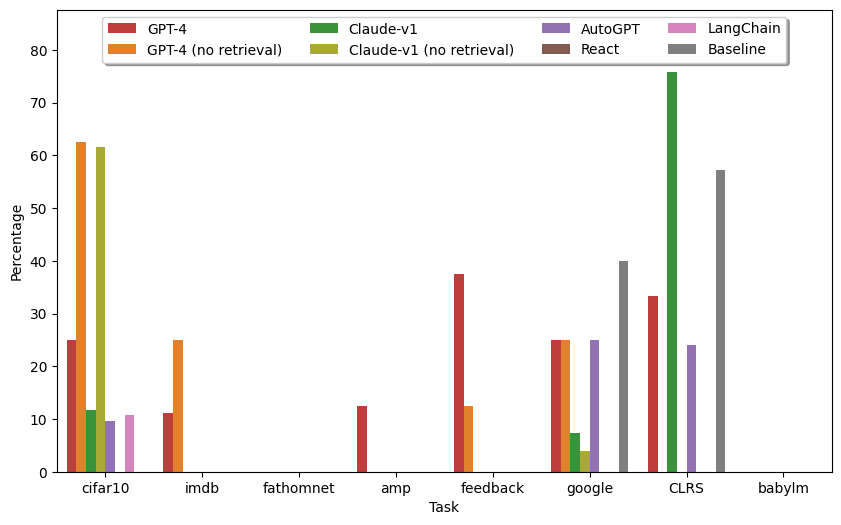

In [966]:
plot(df, "improve_5", "Percentage of runs that improve objective by over 5% at any point", "improve_5")

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/2286894383.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(["task", "exp"]).mean().round(4).reset_index()


Percentage of runs that improves objective by over 5% at the end


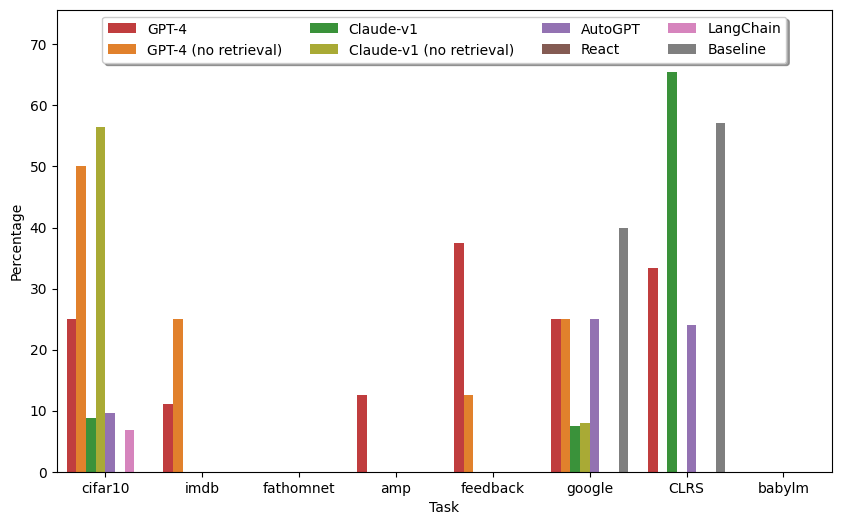

In [967]:
plot(df, "final_improve_5", "Percentage of runs that improves objective by over 5% at the end", "final_improve_5")

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/2286894383.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(["task", "exp"]).mean().round(4).reset_index()


Percentage of runs that improves objective by over 5% at the end


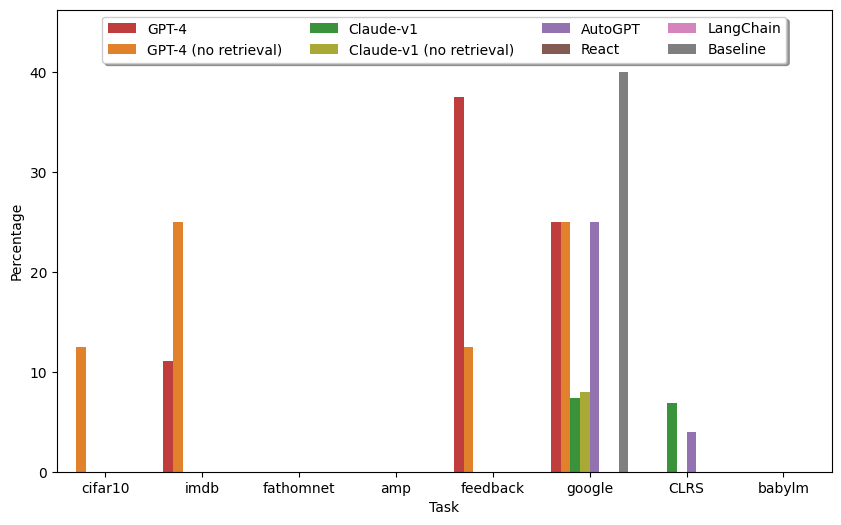

In [968]:
plot(df, "final_improve_30", "Percentage of runs that improves objective by over 5% at the end", "final_improve_30")

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/2286894383.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(["task", "exp"]).mean().round(4).reset_index()


Percentage of runs that made a final submission which improves objective by over 5%


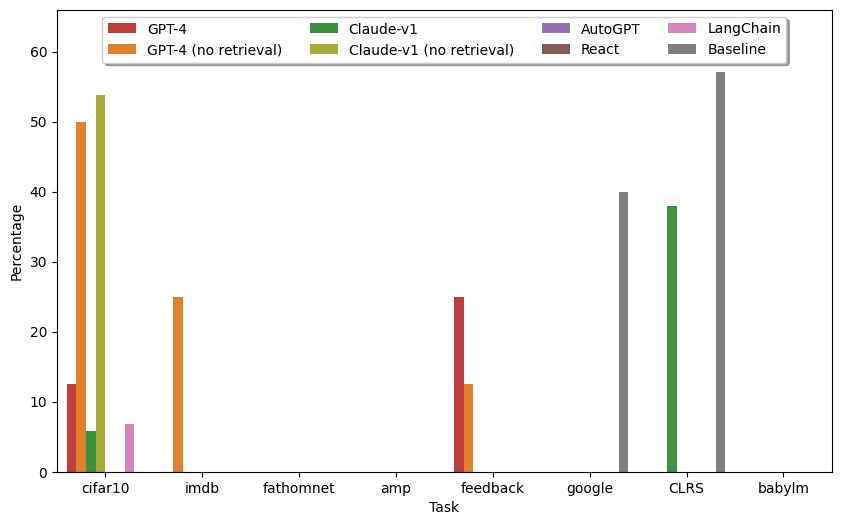

In [969]:
plot(df, "final_submitted_improve_5", "Percentage of runs that made a final submission which improves objective by over 5%", "final_submitted_improve_5")

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/2286894383.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(["task", "exp"]).mean().round(4).reset_index()


Out of runs that made a final submission, Percentage of runs that improves objective by over 5%


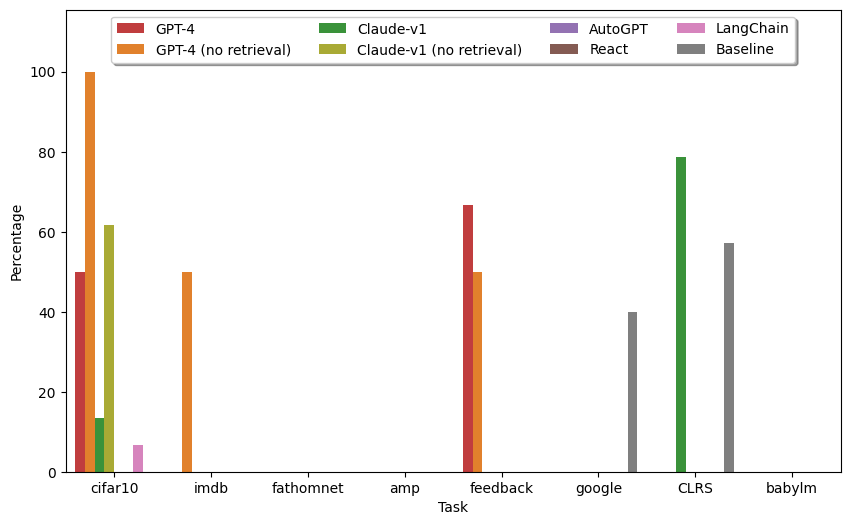

In [970]:
plot(df[df["submitted_final_answer"]], "final_submitted_improve_5", "Out of runs that made a final submission, Percentage of runs that improves objective by over 5%", "final_submitted_improve_5_submitted")

Average best improvement in objective among runs that made any submissions


/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/2286894383.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(["task", "exp"]).mean().round(4).reset_index()


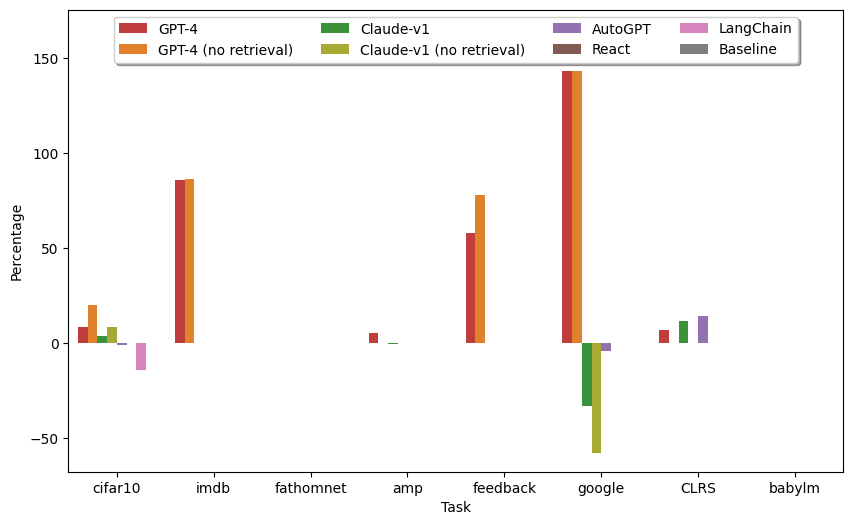

In [971]:
plot(df, "improve", "Average best improvement in objective among runs that made any submissions", "improve")

Average improvement in objective among runs that made a submission at the end.


/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/2286894383.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(["task", "exp"]).mean().round(4).reset_index()


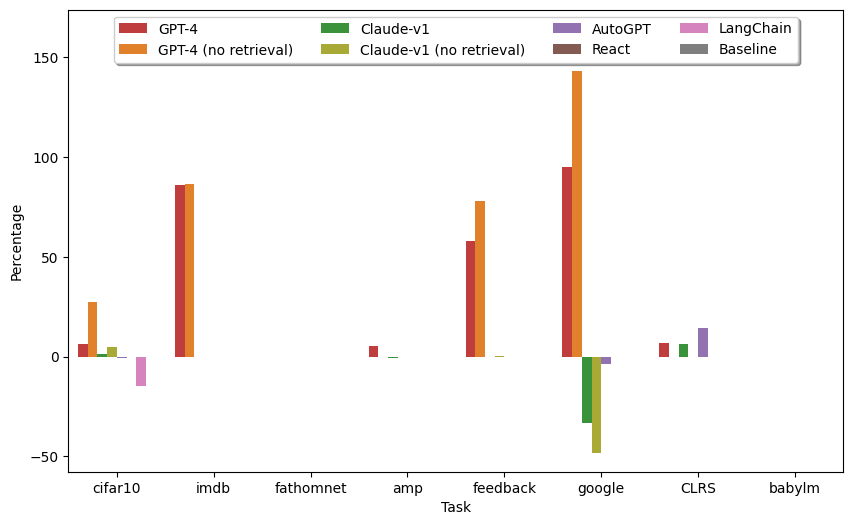

In [972]:
plot(df, "final_improve", "Average improvement in objective among runs that made a submission at the end.", "final_improve")

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/2286894383.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(["task", "exp"]).mean().round(4).reset_index()


Average improvement in objective among runs that made a final submission.


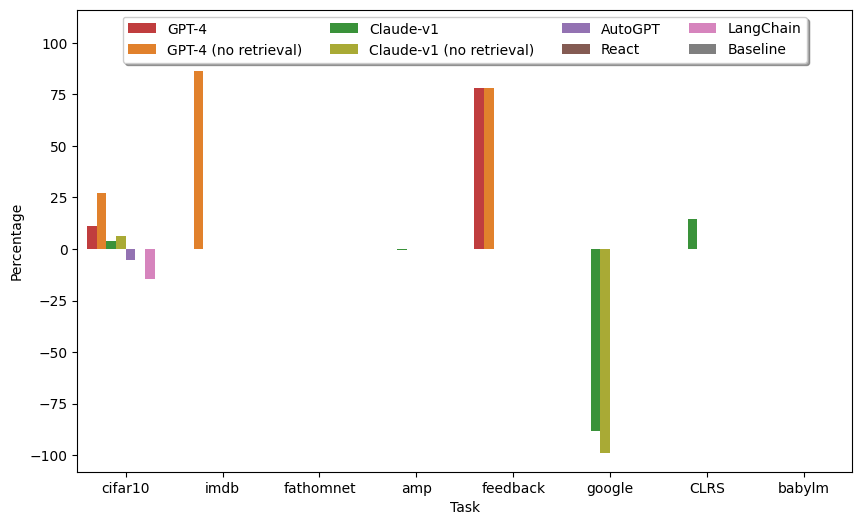

In [973]:
plot(df[df["submitted_final_answer"]], "final_improve", "Average improvement in objective among runs that made a final submission.", "final_improve_submitted")

In [682]:
# df[(df["exp"] != "sanity_check") ][[ "task", "exp", "improve_5", "improve_10", "improve", "final_improve", "increase", "decrease"]].groupby(["task", "exp"]).count()

In [683]:
# df[df["task"] == "amp-parkinsons-disease-progression-prediction"]

In [684]:
# df[df["exp"] == "no_retrieval"]

In [685]:
import matplotlib.pyplot as plt
import numpy as np
df["cleaned_score"] = df["score"].apply(lambda x: [y if y > 0 else np.nan for y in x])
df["cleaned_score_steps"] = df[["exp","score_steps"]].apply(lambda x: np.array(x["score_steps"]) * 3 if x["exp"] not in ["full", "full_gpt4"] else np.array(x["score_steps"]), axis=1)

df["expanded_score"] = df[["cleaned_score","cleaned_score_steps"]].apply(lambda x: [x["cleaned_score"][x["cleaned_score_steps"].tolist().index(i)] if i in x["cleaned_score_steps"] else np.nan  for i in range(52)], axis=1)
# apply moving average
df["expanded_score"] = df["expanded_score"].apply(lambda x: [np.nanmean(x[max(0,i-5):min(i+5, len(x))]) for i in range(len(x))])


/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/2658356428.py:8: RuntimeWarning: Mean of empty slice
  df["expanded_score"] = df["expanded_score"].apply(lambda x: [np.nanmean(x[max(0,i-5):min(i+5, len(x))]) for i in range(len(x))])


In [686]:
def plot_smooth_task(task, exps, colors=colors):
    plt.figure()
    for exp in exps:
        c = colors[exp]        
        plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
    plt.legend()
    plt.title(task)
    plt.show()
    

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)


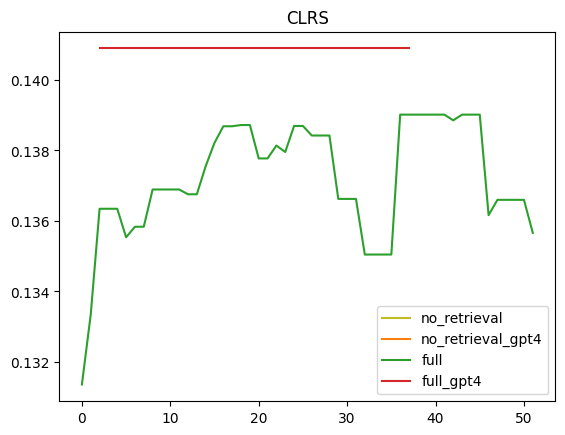

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)


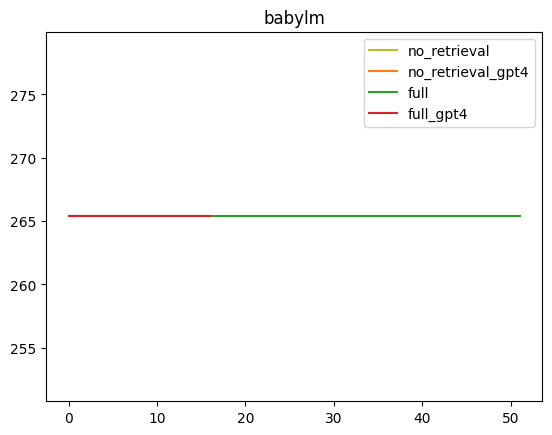

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)


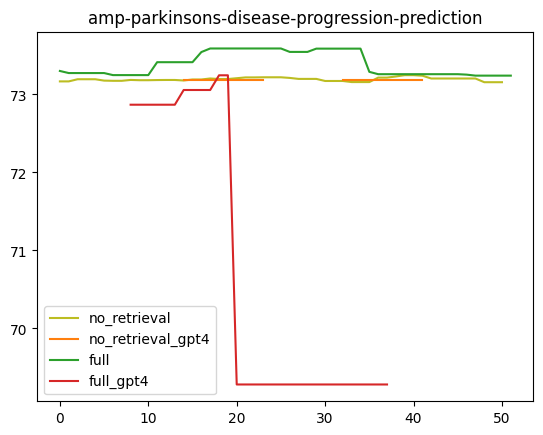

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)


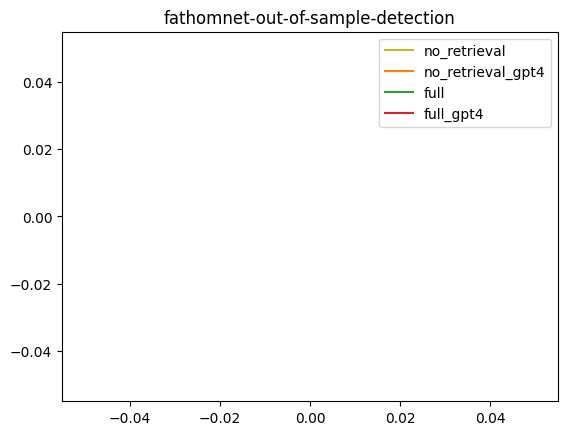

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)


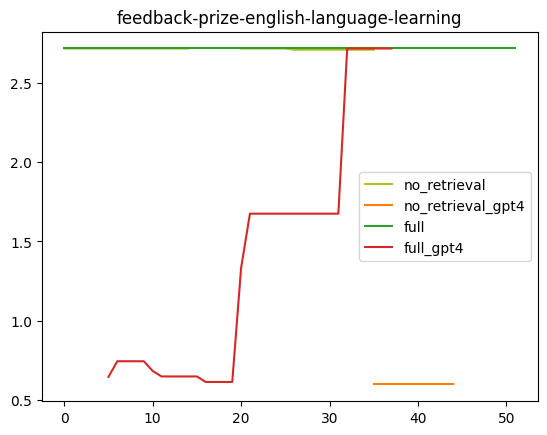

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)


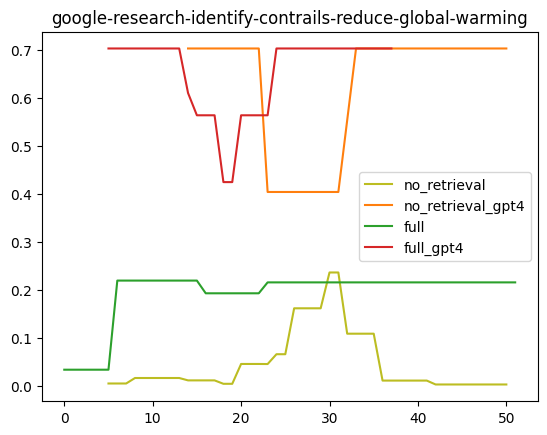

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task)

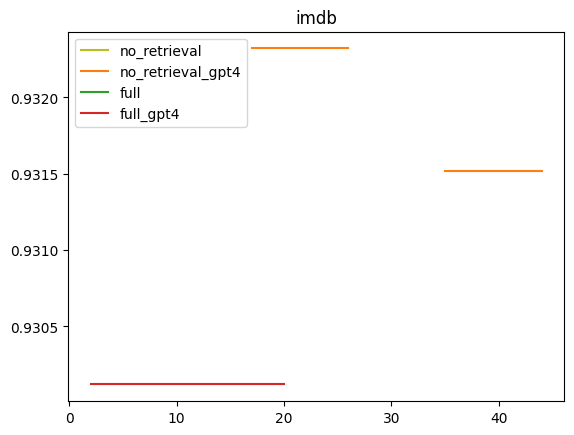

/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)
/var/folders/1_/35jgy4wx44xcshyj_105lnpr0000gp/T/ipykernel_10452/1038523250.py:5: RuntimeWarning: Mean of empty slice
  plt.plot( df[ (df["task"] == task) & (df["exp"] == exp)].agg({"expanded_score": lambda x: np.nanmean(x.tolist(), axis=0)})["expanded_score"], label=exp, color=c)


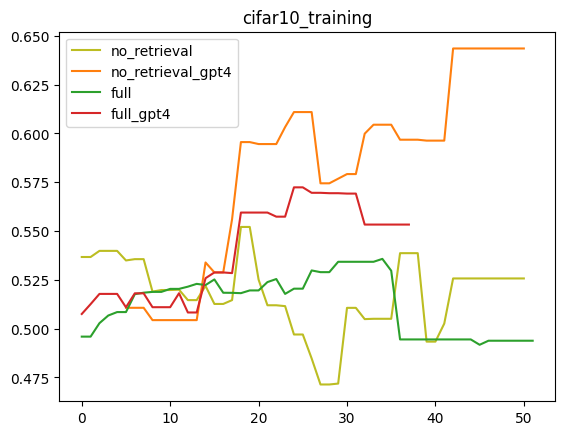

In [687]:
for task in df["task"].unique():
    plot_smooth_task(task, ["no_retrieval", "no_retrieval_gpt4", "full", "full_gpt4"])

In [688]:
def plot_task(task, exps, colors=colors):
    plt.figure()
    for exp in exps:
        c = colors[exp]
        df_plot = df[ (df["task"] == task) & (df["exp"] == exp)]
        
        for i, row in df_plot.iterrows():
            plt.plot(row["cleaned_score_steps"],row["cleaned_score"], color=c)
        plt.title(task)
        # plt.legend(color_scheme)
    plt.show()


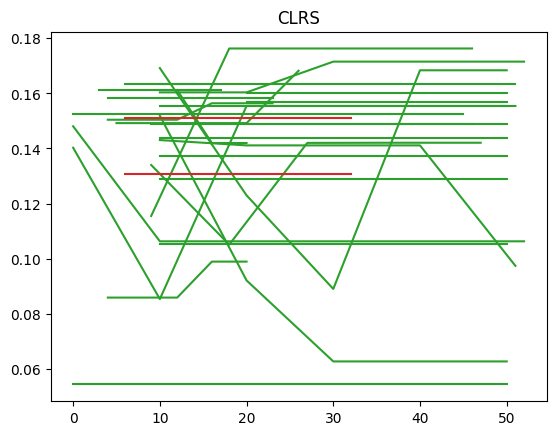

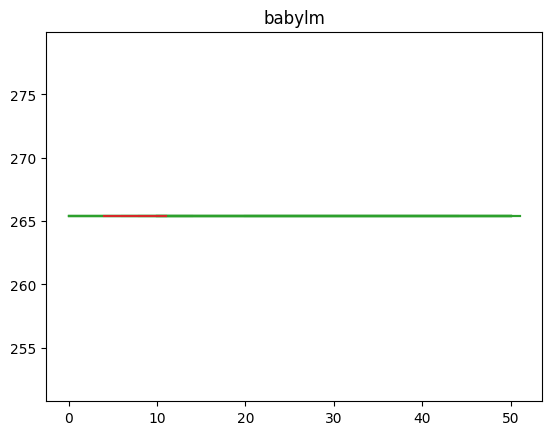

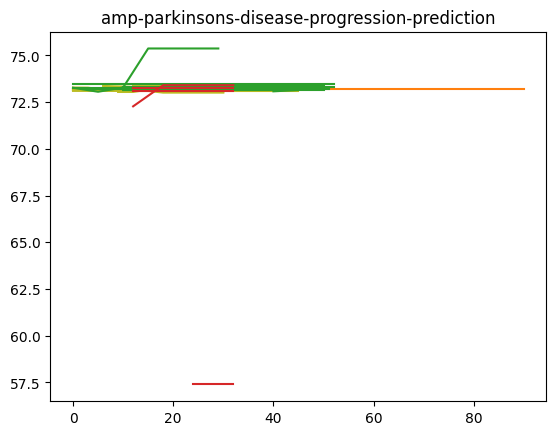

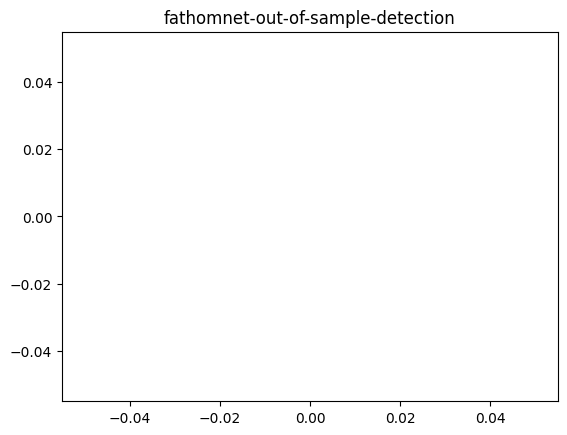

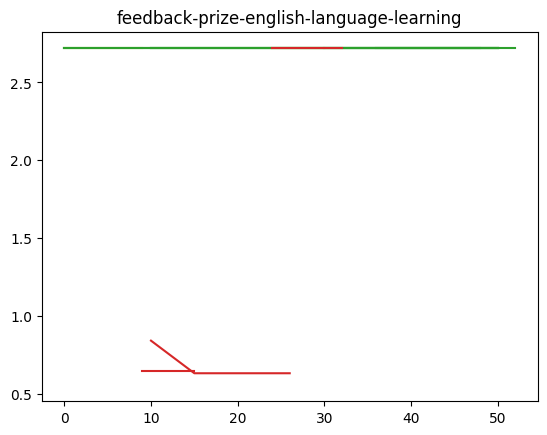

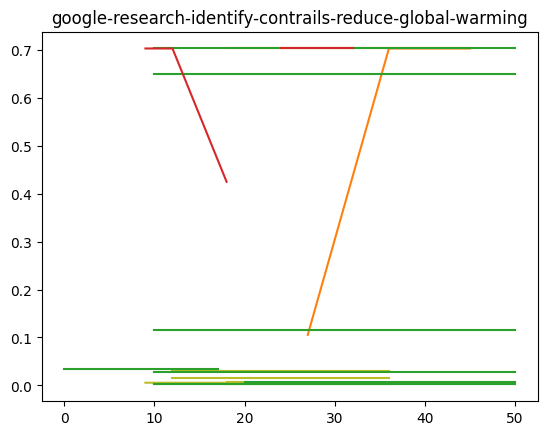

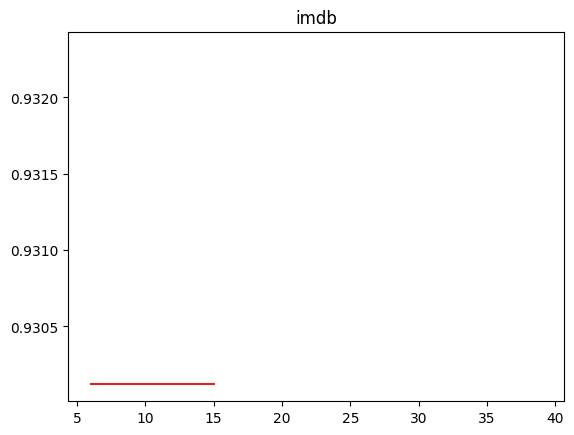

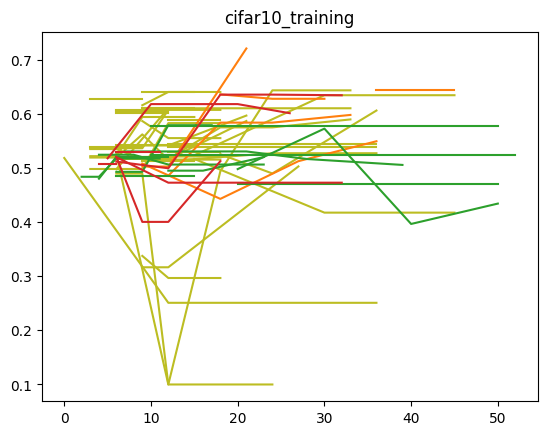

In [689]:
for task in df["task"].unique():
    plot_task(task, ["no_retrieval", "no_retrieval_gpt4", "full", "full_gpt4"])

In [511]:
# plt.plot([np.arange(50)]*4, df[ (df["task"] == "cifar10_training") & (df_plot["exp"] == "full_gpt4")]["cleaned_score"].values.tolist(), label="full")

In [512]:
df[df["submitted_final_answer"]][[ "task", "exp", "improve_5", "improve_10", "improve", "final_improve", "increase", "decrease"]].groupby(["task", "exp"]).mean().round(4)

improve_5  \
task                                               exp                            
CLRS                                               full_long             0.7857   
                                                   sanity_check          0.5714   
amp-parkinsons-disease-progression-prediction      full                  0.0000   
                                                   no_retrieval          0.0000   
                                                   no_retrieval_gpt4     0.0000   
                                                   sanity_check          0.0000   
babylm                                             full_gpt4_long        0.0000   
                                                   full_long             0.0000   
                                                   sanity_check          0.0000   
cifar10_training                                   full                  0.1333   
                                                   full_gpt4             0.5000   
                                                   no_retrieval          0.7059   
                                                   no_retrieval_gpt4     1.0000   
                                                   sanity_check          0.0000   
fathomnet-out-of-sample-detection                  full                  0.0000   
                                                   full_gpt4             0.0000   
                                                   no_retrieval          0.0000   
                                                   sanity_check          0.0000   
feedback-prize-english-language-learning           full                  0.0000   
                                                   full_gpt4             0.6667   
                                                   langchain             0.0000   
                                                   no_retrieval          0.0000   
                                                   no_retrieval_gpt4     0.5000   
                                                   sanity_check          0.0000   
google-research-identify-contrails-reduce-globa... full                  0.0000   
                                                   no_retrieval          0.0000   
                                                   sanity_check          0.4000   
imdb                                               full                  0.0000   
                                                   full_gpt4             0.0000   
                                                   no_retrieval          0.0000   
                                                   no_retrieval_gpt4     0.5000   
                                                   sanity_check          0.0000   

                                                                      improve_10  \
task                                               exp                             
CLRS                                               full_long              0.6429   
                                                   sanity_check           0.4286   
amp-parkinsons-disease-progression-prediction      full                   0.0000   
                                                   no_retrieval           0.0000   
                                                   no_retrieval_gpt4      0.0000   
                                                   sanity_check           0.0000   
babylm                                             full_gpt4_long         0.0000   
                                                   full_long              0.0000   
                                                   sanity_check           0.0000   
cifar10_training                                   full                   0.0667   
                                                   full_gpt4              0.5000   
                                                   no_retrieval           0.5882   
                                                   no_retrieval_gpt4   

In [513]:
df[[ "task", "exp", "improve_5", "improve", "increase", "decrease"]].groupby([ "exp","task"]).count()

improve_5  \
exp               task                                                            
autogpt           CLRS                                                       25   
                  amp-parkinsons-disease-progression-prediction              27   
                  cifar10_training                                           31   
                  fathomnet-out-of-sample-detection                          26   
                  feedback-prize-english-language-learning                   29   
                  google-research-identify-contrails-reduce-globa...         24   
                  imdb                                                       29   
full              amp-parkinsons-disease-progression-prediction              26   
                  cifar10_training                                           34   
                  fathomnet-out-of-sample-detection                          33   
                  feedback-prize-english-language-learning                   31   
                  google-research-identify-contrails-reduce-globa...         27   
                  imdb                                                       32   
full_gpt4         amp-parkinsons-disease-progression-prediction               8   
                  cifar10_training                                            8   
                  fathomnet-out-of-sample-detection                           8   
                  feedback-prize-english-language-learning                    8   
                  google-research-identify-contrails-reduce-globa...          8   
                  imdb                                                        9   
full_gpt4_long    CLRS                                                        9   
                  babylm                                                      8   
full_long         CLRS                                                       29   
                  babylm                                                     26   
langchain         amp-parkinsons-disease-progression-prediction              34   
                  cifar10_training                                           74   
                  fathomnet-out-of-sample-detection                           9   
                  feedback-prize-english-language-learning                   30   
                  google-research-identify-contrails-reduce-globa...          9   
                  imdb                                                       40   
no_retrieval      amp-parkinsons-disease-progression-prediction              36   
                  cifar10_training                                           39   
                  fathomnet-out-of-sample-detection                          25   
                  feedback-prize-english-language-learning                   25   
                  google-research-identify-contrails-reduce-globa...         25   
                  imdb                                                       25   
no_retrieval_gpt4 amp-parkinsons-disease-progression-prediction               8   
                  cifar10_training                                            8   
                  feedback-prize-english-language-learning                    8   
                  google-research-identify-contrails-reduce-globa...          8   
                  imdb                                                        8   
react             amp-parkinsons-disease-progression-prediction              34   
                  cifar10_training                                           34   
                  fathomnet-out-of-sample-detection                          27   
                  feedback-prize-english-language-learning                   27   
                  google-research-identify-contrails-reduce-globa...         27   
                  imdb                                                       27   
sanity_check      CLRS                                                        7   
   

In [514]:
df_submitted = df.dropna()

In [515]:
df_submitted[[ "task", "exp", "improve_5","improve_10","improve", "increase", "decrease"]].groupby(["task", "exp"]).mean().round(4)

improve_5  \
task                                               exp                            
amp-parkinsons-disease-progression-prediction      autogpt               0.0000   
                                                   full                  0.0000   
                                                   full_gpt4             0.2500   
                                                   no_retrieval          0.0000   
                                                   no_retrieval_gpt4     0.0000   
                                                   sanity_check          0.0000   
babylm                                             full_long             0.0000   
cifar10_training                                   autogpt               0.1875   
                                                   full                  0.3077   
                                                   full_gpt4             0.2857   
                                                   langchain             0.5000   
                                                   no_retrieval          0.6216   
                                                   no_retrieval_gpt4     1.0000   
                                                   sanity_check          0.0000   
feedback-prize-english-language-learning           autogpt               0.0000   
                                                   full                  0.0000   
                                                   full_gpt4             0.7500   
                                                   langchain             0.0000   
                                                   no_retrieval          0.0000   
                                                   no_retrieval_gpt4     1.0000   
                                                   sanity_check          0.0000   
google-research-identify-contrails-reduce-globa... autogpt               0.3750   
                                                   full                  0.2500   
                                                   full_gpt4             1.0000   
                                                   no_retrieval          0.1250   
                                                   no_retrieval_gpt4     1.0000   
                                                   sanity_check          0.4000   
imdb                                               full_gpt4             1.0000   
                                                   no_retrieval_gpt4     1.0000   

                                                                      improve_10  \
task                                               exp                             
amp-parkinsons-disease-progression-prediction      autogpt                0.0000   
                                                   full                   0.0000   
                                                   full_gpt4              0.2500   
                                                   no_retrieval           0.0000   
                                                   no_retrieval_gpt4      0.0000   
                                                   sanity_check           0.0000   
babylm                                             full_long              0.0000   
cifar10_training                                   autogpt                0.0000   
                                                   full                   0.2308   
                                                   full_gpt4              0.2857   
                                                   langchain              0.4000   
                                                   no_retrieval           0.5405   
                                                   no_retrieval_gpt4      1.0000   
                                                   sanity_check           0.0000   
feedback-prize-english-language-learning           autogpt                0.0000   
                                                   full             

In [516]:

df_submitted[df_submitted["submitted_final_answer"]][[ "task", "exp", "improve_5","improve_10","improve", "increase", "decrease"]].groupby(["task", "exp"]).mean().round(4)

improve_5  \
task                                               exp                            
amp-parkinsons-disease-progression-prediction      full                  0.0000   
                                                   no_retrieval          0.0000   
                                                   sanity_check          0.0000   
babylm                                             full_long             0.0000   
cifar10_training                                   full                  0.2500   
                                                   full_gpt4             0.5000   
                                                   no_retrieval          0.7188   
                                                   no_retrieval_gpt4     1.0000   
                                                   sanity_check          0.0000   
feedback-prize-english-language-learning           full_gpt4             1.0000   
                                                   no_retrieval          0.0000   
                                                   no_retrieval_gpt4     1.0000   
                                                   sanity_check          0.0000   
google-research-identify-contrails-reduce-globa... full                  0.0000   
                                                   no_retrieval          0.0000   
                                                   sanity_check          0.4000   
imdb                                               no_retrieval_gpt4     1.0000   

                                                                      improve_10  \
task                                               exp                             
amp-parkinsons-disease-progression-prediction      full                    0.000   
                                                   no_retrieval            0.000   
                                                   sanity_check            0.000   
babylm                                             full_long               0.000   
cifar10_training                                   full                    0.125   
                                                   full_gpt4               0.500   
                                                   no_retrieval            0.625   
                                                   no_retrieval_gpt4       1.000   
                                                   sanity_check            0.000   
feedback-prize-english-language-learning           full_gpt4               1.000   
                                                   no_retrieval            0.000   
                                                   no_retrieval_gpt4       1.000   
                                                   sanity_check            0.000   
google-research-identify-contrails-reduce-globa... full                    0.000   
                                                   no_retrieval            0.000   
                                                   sanity_check            0.400   
imdb                                               no_retrieval_gpt4       1.000   

                                                                      improve  \
task                                               exp                          
amp-parkinsons-disease-progression-prediction      full                0.0002   
                                                   no_retrieval        0.0003   
                                                   sanity_check       -0.0000   
babylm                                             full_long           0.0000   
cifar10_training                                   full                0.0441   
                                                   full_gpt4           0.1282   
                                                   no_retrieval        0.1177   
                                                   no_retrieval_gpt4   0.2764   
                                                   sanity_check       -0.0000   
feed

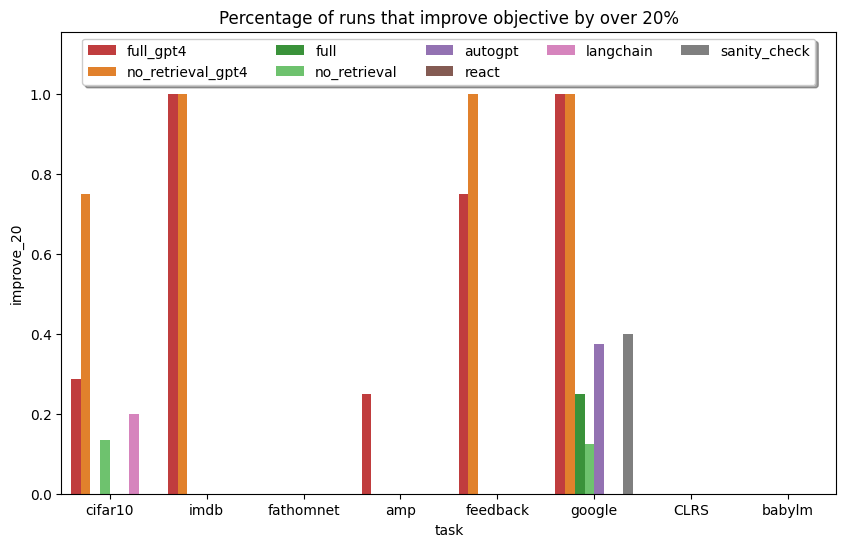

In [519]:
plot(df_submitted, "improve_20", "Percentage of runs that improve objective by over 20%")

In [501]:
# "prompt_tokens", "completed_tokens", "num_steps", 

In [67]:
df = df[df["final_score"] > 0]

In [23]:
df[df["submitted_final_answer"]][[ "task", "exp", "run", "final_score", "max_score"]].groupby(["task", "exp"]).describe()

final_score  \
                                                                      count   
task                                               exp                        
CLRS                                               full                 5.0   
                                                   sanity_check         5.0   
amp-parkinsons-disease-progression-prediction      full                15.0   
                                                   sanity_check         5.0   
cifar10_training                                   full                13.0   
                                                   sanity_check         5.0   
fathomnet-out-of-sample-detection                  full                11.0   
feedback-prize-english-language-learning           full                 3.0   
                                                   sanity_check         5.0   
google-research-identify-contrails-reduce-globa... full                 1.0   
imdb                                               full                 6.0   
                                                   sanity_check         5.0   
kaggle_training_class                              full                 2.0   
kaggle_training_reg                                full                 3.0   

                                                                            \
                                                                      mean   
task                                               exp                       
CLRS                                               full           0.263184   
                                                   sanity_check   0.563379   
amp-parkinsons-disease-progression-prediction      full          31.097115   
                                                   sanity_check  73.207778   
cifar10_training                                   full          -0.059154   
                                                   sanity_check   0.508680   
fathomnet-out-of-sample-detection                  full          -0.545455   
feedback-prize-english-language-learning           full           0.239482   
                                                   sanity_check   2.718447   
google-research-identify-contrails-reduce-globa... full          -1.000000   
imdb                                               full          -0.749940   
                                                   sanity_check   0.499560   
kaggle_training_class                              full          -1.000000   
kaggle_training_reg                                full          -1.000000   

                                                                            \
                                                                       std   
task                                               exp                       
CLRS                                               full           0.713218   
                                                   sanity_check   0.150286   
amp-parkinsons-disease-progression-prediction      full          41.664355   
                                                   sanity_check   0.217949   
cifar10_training                                   full           0.774376   
                                                   sanity_check   0.021890   
fathomnet-out-of-sample-detection                  full           0.522233   
feedback-prize-english-language-learning           full           2.146846   
                                                   sanity_check   0.000000   
google-research-identify-contrails-reduce-globa... full                NaN   
imdb                                               full           0.612519   
                                                   sanity_check   0.004007   
kaggle_training_class                              full           0.000000   
kaggle_training_reg                                full           0.000000   

                                                                  

In [70]:
df[[ "task", "exp", "run", "final_score"]].groupby(["task", "exp"]).describe()

final_score  \
                                                                      count   
task                                               exp                        
CLRS                                               full                 9.0   
                                                   sanity_check         5.0   
amp-parkinsons-disease-progression-prediction      full                 8.0   
                                                   sanity_check         5.0   
cifar10_training                                   full                 5.0   
                                                   sanity_check         5.0   
feedback-prize-english-language-learning           full                 2.0   
                                                   sanity_check         5.0   
google-research-identify-contrails-reduce-globa... full                 1.0   
imdb                                               full                 6.0   
                                                   sanity_check         5.0   

                                                                            \
                                                                      mean   
task                                               exp                       
CLRS                                               full           0.640299   
                                                   sanity_check   0.563379   
amp-parkinsons-disease-progression-prediction      full          77.768800   
                                                   sanity_check  73.207778   
cifar10_training                                   full           0.510640   
                                                   sanity_check   0.508680   
feedback-prize-english-language-learning           full           2.718447   
                                                   sanity_check   2.718447   
google-research-identify-contrails-reduce-globa... full           0.649848   
imdb                                               full           0.499367   
                                                   sanity_check   0.499560   

                                                                            \
                                                                       std   
task                                               exp                       
CLRS                                               full           0.109104   
                                                   sanity_check   0.150286   
amp-parkinsons-disease-progression-prediction      full          12.955018   
                                                   sanity_check   0.217949   
cifar10_training                                   full           0.050905   
                                                   sanity_check   0.021890   
feedback-prize-english-language-learning           full           0.000000   
                                                   sanity_check   0.000000   
google-research-identify-contrails-reduce-globa... full                NaN   
imdb                                               full           0.002855   
                                                   sanity_check   0.004007   

                                                                            \
                                                                       min   
task                                               exp                       
CLRS                                               full           0.459473   
                                                   sanity_check   0.415039   
amp-parkinsons-disease-progression-prediction      full          73.075370   
                                                   sanity_check  72.910164   
cifar10_training                                   full           0.434000   
                                                   sanity_check   0.485000   
feedback-prize-english-language-learning           full           2.7

In [72]:
130000*8*15

15600000

In [70]:
df[df["final_score"] > -1]

,task,exp,run,path,summary,rubric_questions,score,submitted_final_answer,final_score,total_time,error,prompt_tokens,completed_tokens,num_steps
41,cifar10_training,full,1687364120,final_exp_logs/full/cifar10_training/168736412...,,{},[0.5199],True,0.519900,676.999044,,44319,4217,23
42,cifar10_training,full,1687313414,final_exp_logs/full/cifar10_training/168731341...,,{},[0.5765],False,0.576500,1323.702572,,131246,19746,50
43,cifar10_training,full,1687313410,final_exp_logs/full/cifar10_training/168731341...,,{},[0.5056],False,0.505600,1548.652150,,163373,29433,50
45,cifar10_training,full,1687313403,final_exp_logs/full/cifar10_training/168731340...,,{},[0.5172],True,0.517200,313.581552,,21762,3293,11
48,cifar10_training,full,1687313399,final_exp_logs/full/cifar10_training/168731339...,,{},[0.434],False,0.434000,1325.933142,,149177,20969,50
63,google-research-identify-contrails-reduce-glob...,full,1687351028,final_exp_logs/full/google-research-identify-c...,,{},[0.649847986992879],False,0.649848,1258.373755,,136616,19892,50
86,fathomnet-out-of-sample-detection,full,1687335065,final_exp_logs/full/fathomnet-out-of-sample-de...,,{},[0.0],True,0.000000,1205.950522,,96558,15165,41
88,fathomnet-out-of-sample-detection,full,1687335084,final_exp_logs/full/fathomnet-out-of-sample-de...,,{},[0.0],False,0.000000,1515.017388,,139970,17312,50
90,fathomnet-out-of-sample-detection,full,1687335089,final_exp_logs/full/fathomnet-out-of-sample-de...,,{},[0.0],False,0.000000,2241.053716,,129560,18130,50
92,fathomnet-out-of-sample-detection,full,1687335093,final_exp_logs/full/fathomnet-out-of-sample-de...,,{},[0.0],False,0.000000,1039.209095,,105519,15745,24


In [50]:
path = "final_exp_logs/full/cifar10_training/1687364134/env_log/trace.json"

In [51]:
estimate_tokens(path)

(144208, 17802, 52)

['final_exp_logs/full/cifar10_training/1687364134/env_log/../agent_log/step_13_summary_log.log',
 'final_exp_logs/full/cifar10_training/1687364134/env_log/../agent_log/step_7_summary_log.log',
 'final_exp_logs/full/cifar10_training/1687364134/env_log/../agent_log/step_12_log.log',
 'final_exp_logs/full/cifar10_training/1687364134/env_log/../agent_log/step_9_summary_log.log',
 'final_exp_logs/full/cifar10_training/1687364134/env_log/../agent_log/step_6_summary_log.log',
 'final_exp_logs/full/cifar10_training/1687364134/env_log/../agent_log/step_3_log.log',
 'final_exp_logs/full/cifar10_training/1687364134/env_log/../agent_log/step_7_log.log',
 'final_exp_logs/full/cifar10_training/1687364134/env_log/../agent_log/step_12_summary_log.log',
 'final_exp_logs/full/cifar10_training/1687364134/env_log/../agent_log/step_8_summary_log.log',
 'final_exp_logs/full/cifar10_training/1687364134/env_log/../agent_log/step_2_log.log',
 'final_exp_logs/full/cifar10_training/1687364134/env_log/../agent_lo

In [152]:
def sanitize_json_string(s):
    s = s.strip("```json").strip("```").strip()
    s = s.replace('\\', '\\\\')  # Escape backslashes first
    s = s.replace('/', '\\/')  # Escape forward slashes
    s = s.replace('\b', '\\b')  # Escape backspaces
    s = s.replace('\f', '\\f')  # Escape form feeds
    s = s.replace('\r', '\\r')  # Escape carriage returns
    s = s.replace('\t', '\\t')  # Escape horizontal tabs
    # triple quotes are a problem
    return re.sub(r'"([^"]*)"', lambda m: '"' + m.group(1).replace('\n', '\\n').replace('\"', '\\"') + '"', s)

In [153]:
d = """{  
"script_name": "train.py",     
"edit_instruction": "Add the following code to evaluate the model and save predictions:   

#evaluate model and print accuracy on test set, also save the predictions of probabilities per class   to submission.csv   
 test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)   
 test_loss, test_acc = model.evaluate(test_dataloader)   
 print(f\"Test accuracy: {test_acc}\")       

submission = pd.DataFrame(columns=list(range(2)), index=range(len(imdb[\"test\"])))   
 for i, example in enumerate(test_dataset):     
     submission.loc[i] = torch.nn.functional.softmax(model(example[0].unsqueeze(0)), dim=1)[:,1].detach().numpy()   
submission.to_csv(\"submission.csv\")     
",  
"save_name": "train.py"}"""

In [161]:
def parse_action_input_by_matching(s):
    entries = ["script_name", "edit_instruction", "save_name"]
    index = s.find('{')
    s = s[index + 1:]
    index = s.rfind('}')
    s = s[:index]
    pattern = ""
    for e in entries:
        pattern += f'"{e}":([\s\S]*),\s*'
    pattern = pattern[:-4]
    result = re.search(pattern, s, re.MULTILINE)

    if result is None:
        raise Exception("Invalid: " + s)
    # return [r.strip().strip('\"') for r in result.groups()]
    result = { e: r.strip().strip('\"') for e, r in zip(entries, result.groups())}
    if "content" in result:
        import ast
        result["content"] = ast.literal_eval("\"" + result["content"] + "\"")
    return result
   

In [160]:
sanitize_json_string(d)

'{  \n"script_name": "train.py",     \n"edit_instruction": "Add the following code to evaluate the model and save predictions:   \\n\\n#evaluate model and print accuracy on test set, also save the predictions of probabilities per class   to submission.csv   \\n test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)   \\n test_loss, test_acc = model.evaluate(test_dataloader)   \\n print(f"Test accuracy: {test_acc}")       \\n\\nsubmission = pd.DataFrame(columns=list(range(2)), index=range(len(imdb["test"])))   \\n for i, example in enumerate(test_dataset):     \\n     submission.loc[i] = torch.nn.functional.softmax(model(example[0].unsqueeze(0)), dim=1)[:,1].detach().numpy()   \\nsubmission.to_csv("submission.csv")     \\n",  \n"save_name": "train.py"}'

In [157]:
json.loads(sanitize_json_string(d))

JSONDecodeError: Expecting ',' delimiter: line 3 column 366 (char 401)

In [159]:
json.loads("{\"f\": \":\"\"}")

JSONDecodeError: Expecting ',' delimiter: line 1 column 10 (char 9)